In [1]:
import tensorflow as tf

from qiskit import Aer, QuantumCircuit, QuantumRegister, transpile, assemble, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit.opflow import I, X, Y, Z, StateFn, PauliExpectation
from qiskit.quantum_info import Pauli

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Layer, Flatten, Input

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [3]:
tf.executing_eagerly()

True

In [4]:
fano_data = pd.read_csv("./../datasets/signal_080_peak_1_fano_adjust.csv")

In [5]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [6]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

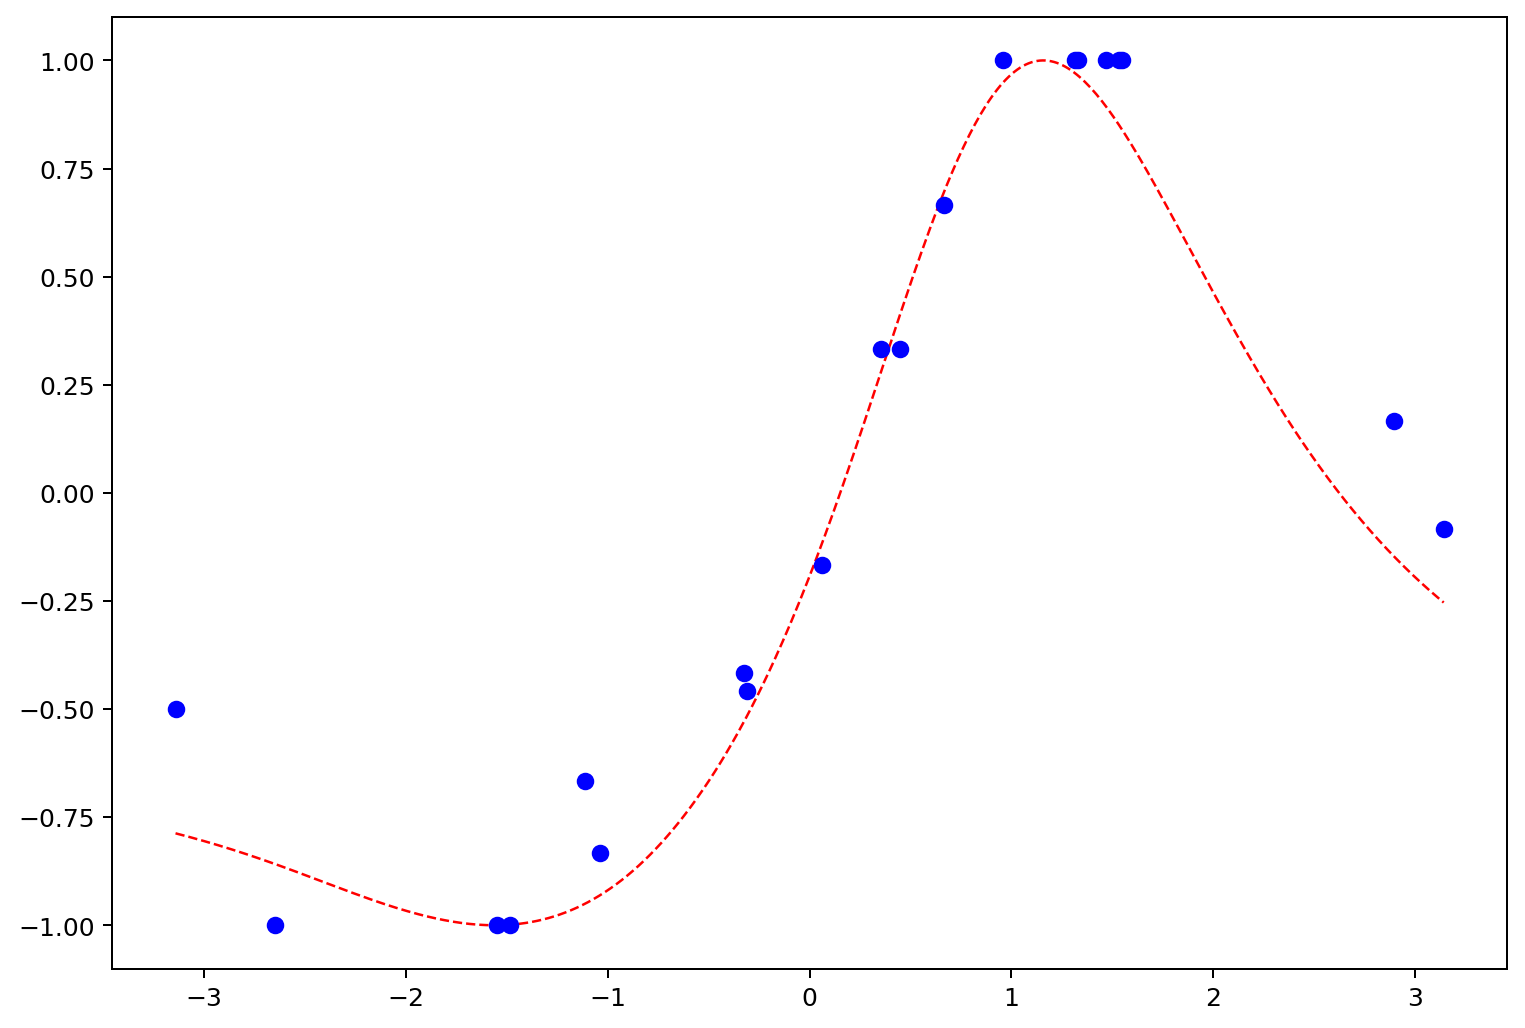

In [7]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False))

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

XX = X_[indices].reshape(-1,1)
yy = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

yy = detrend(yy)

XX = scale(XX)
yy = scale(yy, -1, 1)

X_ = scale(X_)
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(XX, yy, "bo", label = 'Points to fit')
plt.show()

In [8]:
def quantum_layer(initial_parameters, num_qubits):

    quantumRegister = QuantumRegister(num_qubits)
    quantumCircuit = QuantumCircuit(quantumRegister)
    
    quantumCircuit.h(range(num_qubits))

    for i in range(len(initial_parameters)):
        angles = initial_parameters[i]
        for j in range(len(angles)):
            quantumCircuit.ry(angles[j] * np.pi, i)

    psi = StateFn(quantumCircuit)

    operatorI = I ^ I ^ I ^ I ^ I ^ I ^ I ^ I
    operatorZ = Z ^ Z ^ Z ^ Z ^ Z ^ Z ^ Z ^ Z
    operatorX = X ^ X ^ X ^ X ^ X ^ X ^ X ^ X
    operatorY = Y ^ Y ^ Y ^ Y ^ Y ^ Y ^ Y ^ Y

    # two ways of doing the same thing
    expectationI = (~psi @ operatorI @ psi).eval()
    expectationX = (~psi @ operatorX @ psi).eval()
    expectationZ = psi.adjoint().compose(operatorZ).compose(psi).eval().real
    expectationY = (~psi @ operatorY @ psi).eval()

    
    expectationZ = np.abs(np.real(expectationZ))
    expectations = [expectationX, expectationY, expectationZ, 
                    expectationX, expectationY, expectationZ, expectationZ, 
                    expectationX + expectationY + expectationZ] 

    
    return np.array(expectations)

In [9]:
class Linear(Layer):
    
    def __init__(self, batch_size = 10, units = 1, input_dim=1, num_qubits = 1,**kwargs):
        super(Linear, self).__init__(**kwargs)
        self.num_qubits = num_qubits
        
        self.w = self.add_weight(
            shape=(input_dim, units), initializer="random_normal", trainable=True
        )
        
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)


    def get_config(self):
        config = super(Linear, self).get_config()
        return config

    def call(self, inputs):
        
        if (tf.executing_eagerly()):
            
            final_output = []
        
            for i in range(inputs.shape[0]):
                pred = quantum_layer(inputs.numpy(), self.num_qubits)
                final_output.append(list(pred))

            return tf.convert_to_tensor(final_output)
        
        return inputs

In [10]:
n_qubits = 8
data_dimension = 1

In [11]:
def sequential_model():

    layers_arr = []
    layers_arr.append(Dense(n_qubits, activation = 'relu', input_shape=[1], name ="dense1"))
    layers_arr.append(Linear(1, num_qubits = n_qubits, name="quantum"))
    layers_arr.append(Dense(data_dimension, activation="linear", name ="dense2"))
    layers_arr.append(Dense(1, name ="dense3"))

    return Sequential(layers_arr)

In [12]:
#model = non_sequential_model()
model = sequential_model()
    
opt = Adam(learning_rate=0.01)
#opt = SGD(learning_rate=0.01)

model.compile(opt, loss='mse', metrics=["accuracy"], run_eagerly=True)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 8)                 16        
_________________________________________________________________
quantum (Linear)             (None, 8)                 2         
_________________________________________________________________
dense2 (Dense)               (None, 1)                 9         
_________________________________________________________________
dense3 (Dense)               (None, 1)                 2         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(XX, yy, epochs=10, batch_size=8, validation_split = 0.25)

#history = model.fit(XX, yy, epochs = 50, batch_size = 8)


Epoch 1/10
2/2 [==============================] - 3s 2s/step - loss: 0.5810 - accuracy: 0.0000e+00 - val_loss: 0.4902 - val_accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 3s 2s/step - loss: 0.5523 - accuracy: 0.0000e+00 - val_loss: 0.5062 - val_accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 3s 2s/step - loss: 0.5589 - accuracy: 0.0000e+00 - val_loss: 0.5213 - val_accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 3s 2s/step - loss: 0.5906 - accuracy: 0.0000e+00 - val_loss: 0.5458 - val_accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 3s 2s/step - loss: 0.5583 - accuracy: 0.0000e+00 - val_loss: 0.5627 - val_accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 3s 2s/step - loss: 0.5111 - accuracy: 0.0000e+00 - val_loss: 0.5729 - val_accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 3s 2s/step - loss: 0.5549 - accuracy: 0.0000e+00 - val_loss: 0.5837 - val_accura

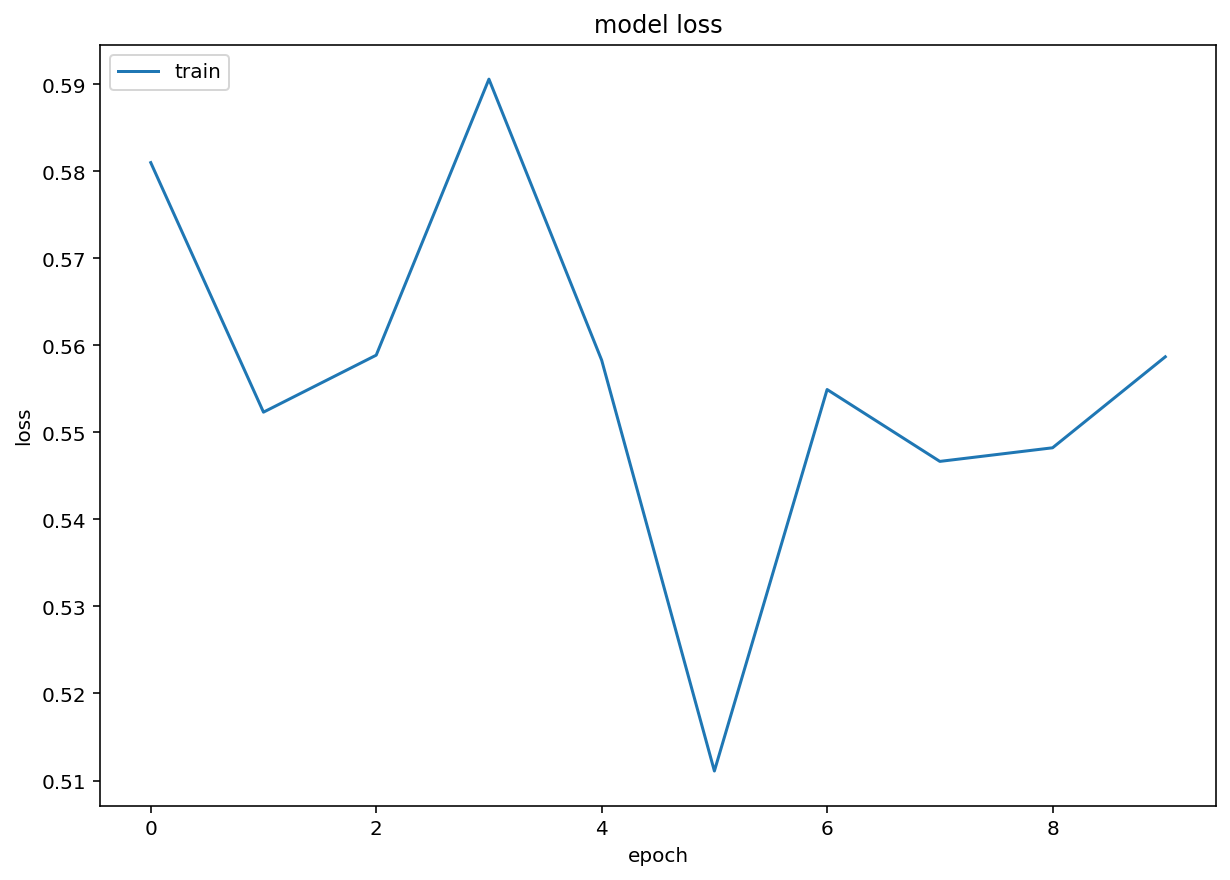

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
y_predict = model.predict(X_)

In [17]:
y_predict_smooth = smooth(y_predict)

In [ ]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(XX, yy, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot prediction
plt.plot(X_, y_predict[:,0], "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth[:,0], "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [ ]:
print("Score: %.10f" % r2_score(y_, y_predict))